In [1]:
WORKSPACE_PATH = 'workspace'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [3]:
import json

def json_read(data_path):
    with open(data_path, 'r') as data:
        data = json.load(data)
    return data

In [4]:
XML_NAME = '/instances_default.json'
DATA_PATH = ANNOTATION_PATH+'/original'+ XML_NAME
data = json_read(DATA_PATH)


Read Json

In [5]:
images = []
bounding_boxes = []
labels = []
image_height = 1920
image_width = 1080

for image in data['images']:
    one_image = []
    one_image.append(image['id'])
    one_image.append(image['file_name'])
    images.append(one_image)

for annotation in data['annotations']:
    one_box = []
    one_box.append(annotation['bbox'])
    #one_box.append(annotation['id'])
    #one_box.append(annotation['image_id'])
    bounding_boxes.append(one_box)

print(images)
print(bounding_boxes)


[[1, 'BafoegAntragSeite1Bild1.jpeg'], [2, 'BafoegAntragSeite1Bild2.jpeg'], [3, 'BafoegAntragSeite1Bild3.jpeg']]
[[[192.53, 680.36, 536.13, 282.34]], [[188.04, 1253.83, 549.3, 132.74]], [[192.87, 963.59, 535.84, 287.9]], [[193.48, 597.5, 552.72, 288.8]], [[192.3, 1169.7, 551.84, 128.4]], [[194.17, 888.48, 550.83, 277.32]], [[139.8, 613.2, 554.8, 287.4]], [[139.8, 1194.57, 558.6, 130.23]], [[140.21, 904.8, 557.59, 284.6]]]


In [33]:
def draw_bounding_boxes(image, box):
    img = cv2.imread(image)
    print(box)
    #for box in boxes: 
    cv2.rectangle(img, (192, 680), (536, 282), (0, 255, 0), 1)

    #cv2.rectangle(img, int((box[0], box[1])), (int(box[0]+ box[2]), int(box[1] + box[3])), (0, 255, 0), 1)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

draw_bounding_boxes(IMAGE_PATH+'/original'+ images[0][1],bounding_boxes[0])



[[192.53, 680.36, 536.13, 282.34]]


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Resize images and boxes

In [6]:
def resize_imgaes(input_path, output_path, height, width):
    image =  cv2.imread(input_path)
    resized_image = cv2.resize(image, (height, width))
    #name = image_name + height + 'x' + width
    cv2.imwrite(output_path, resized_image)
    #return resized_image
    

def resize_bounding_boxes_and_area(input_path,bounding_boxes, height, width):
    image =  cv2.imread(input_path)
    height_ratio = height / image.shape[0]
    width_ratio = width / image.shape[1]
    
    for box in bounding_boxes:
        resized_boxes = []
        resized_area = 0

        x = np.round(box[0]*width_ratio,2)#int(np.round(box[0]*width_ratio))
        y = np.round(box[1]*height_ratio,2)#int(np.round(box[1]*height_ratio))
        x_width = np.round(box[2]*width_ratio,2)#int(np.round(box[2]*width_ratio))
        y_height = np.round(box[3]*height_ratio,2)#int(np.round(box[3]*height_ratio))
        resized_boxes.append([x, y, x_width, y_height])

        resized_area = x_width * y_height

    return x, y, x_width, y_height, resized_area


Bildgröße zum resizen wählen und Verzeichnisse erstellen

In [7]:
import os

height = 224
width = 224
OUTPUT_PATH_IMAGES = IMAGE_PATH + '/' + str(height) + 'x' + str(width)
OUTPUTPATH_ANNOTATIONS = ANNOTATION_PATH + '/' + str(height) + 'x' + str(width)

os.makedirs(OUTPUT_PATH_IMAGES, exist_ok=True)
os.makedirs(OUTPUTPATH_ANNOTATIONS, exist_ok=True)

#Copy XML Doc in new ANNOTATIONPATH
with open(DATA_PATH, 'r') as source_file:
    data = json.load(source_file)
with open(OUTPUTPATH_ANNOTATIONS + XML_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    


Resize Bilbder und Bboxen und schreibe diese in das neue Berzeichnis und die neue Datei

In [8]:
#Resize Images
for img in range(len(images)):
    resize_imgaes(IMAGE_PATH+'/original'+ '/' +images[img][1], OUTPUT_PATH_IMAGES+ '/' +images[img][1], height, width)


with open(OUTPUTPATH_ANNOTATIONS + XML_NAME, 'r') as json_data:
    data = json.load(json_data)


#Resize BBox and area
for i, annotation in enumerate(data['annotations']):
    calculate_resize = resize_bounding_boxes_and_area(IMAGE_PATH+'/original'+ '/' +images[0][1],bounding_boxes[i], height, width)
    new_box = calculate_resize[0],calculate_resize[1],calculate_resize[2],calculate_resize[3]
    new_area = calculate_resize[4]
    annotation['bbox'] = new_box
    annotation['area'] = new_area

#Change height/width
for image in data['images']:
    image['height']=height
    image['width']=width

with open(OUTPUTPATH_ANNOTATIONS + XML_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    

[192.53, 680.36, 536.13, 282.34]
(39.93, 79.38, 111.2, 32.94)
151370.94420000003
3662.928
[188.04, 1253.83, 549.3, 132.74]
(39.0, 146.28, 113.93, 15.49)
72914.08200000001
1764.7757000000001
[192.87, 963.59, 535.84, 287.9]
(40.0, 112.42, 111.14, 33.59)
154268.336
3733.1926000000003
[193.48, 597.5, 552.72, 288.8]
(40.13, 69.71, 114.64, 33.69)
159625.536
3862.2216
[192.3, 1169.7, 551.84, 128.4]
(39.88, 136.46, 114.46, 14.98)
70856.25599999992
1714.6108
[194.17, 888.48, 550.83, 277.32]
(40.27, 103.66, 114.25, 32.35)
152756.1756
3695.9875
[139.8, 613.2, 554.8, 287.4]
(29.0, 71.54, 115.07, 33.53)
159449.51999999996
3858.2971
[139.8, 1194.57, 558.6, 130.23]
(29.0, 139.37, 115.86, 15.19)
72746.478
1759.9134
[140.21, 904.8, 557.59, 284.6]
(29.08, 105.56, 115.65, 33.2)
158690.11400000006
3839.5800000000004


Erstelle TFRecords

In [9]:
import pprint
#RECORDS_DATA_PATH=ANNOTATION_PATH+'/original'+ XML_NAME
RECORDS_DATA_PATH = OUTPUTPATH_ANNOTATIONS + XML_NAME

with open(RECORDS_DATA_PATH, "r") as f:
    annotations = json.load(f)["annotations"]

print(f"Number of images: {len(annotations)}")
pprint.pprint(annotations[8])

num_samples = 1#4096
num_tfrecords = len(annotations) // num_samples
if len(annotations) % num_samples:
    num_tfrecords += 1  # add one record if there are any remaining samples


Number of images: 9
{'area': 3839.5800000000004,
 'attributes': {'keyframe': True,
                'occluded': False,
                'rotation': 0.0,
                'track_id': 2},
 'bbox': [29.08, 105.56, 115.65, 33.2],
 'category_id': 3,
 'id': 9,
 'image_id': 3,
 'iscrowd': 0,
 'segmentation': []}


TFRecords Hilfsfunktionen

In [10]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "area": float_feature(example["area"]),
        "bbox": float_feature_list(example["bbox"]),
        "category_id": int64_feature(example["category_id"]),
        "id": int64_feature(example["id"]),
        "image_id": int64_feature(example["image_id"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "area": tf.io.FixedLenFeature([], tf.float32),
        "bbox": tf.io.VarLenFeature(tf.float32),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example


Generierung TFRecords

In [20]:
tfrecords_dir = OUTPUTPATH_ANNOTATIONS
images_dir = OUTPUT_PATH_IMAGES

split_ratio = 0.8

num_samples = len(annotations)
print(len(annotations))

num_train_samples = int(split_ratio * num_samples)
num_test_samples = num_samples - num_train_samples

np.random.shuffle(annotations)

train_samples = annotations[:num_train_samples]
test_samples = annotations[num_train_samples:]

#Train
with tf.io.TFRecordWriter(tfrecords_dir + "/train.tfrec") as writer:
    for sample in train_samples:
        image_path = f"{images_dir}/{sample['image_id']:012d}.jpeg"
        image = tf.io.decode_jpeg(tf.io.read_file(image_path))
        example = create_example(image, image_path, sample)
        writer.write(example.SerializeToString())
#Test
with tf.io.TFRecordWriter(tfrecords_dir + "/test.tfrec") as writer:
    for sample in test_samples:
        image_path = f"{images_dir}/{sample['image_id']:012d}.jpeg"
        image = tf.io.decode_jpeg(tf.io.read_file(image_path))
        example = create_example(image, image_path, sample)
        writer.write(example.SerializeToString())


9


TFRecord Beispiel

bbox: [ 29.    71.54 115.07  33.53]
area: 3858.297119140625
category_id: 1
id: 7
image_id: 3
path: b'workspace/images/224x224/000000000003.jpeg'
Image shape: (224, 224, 3)


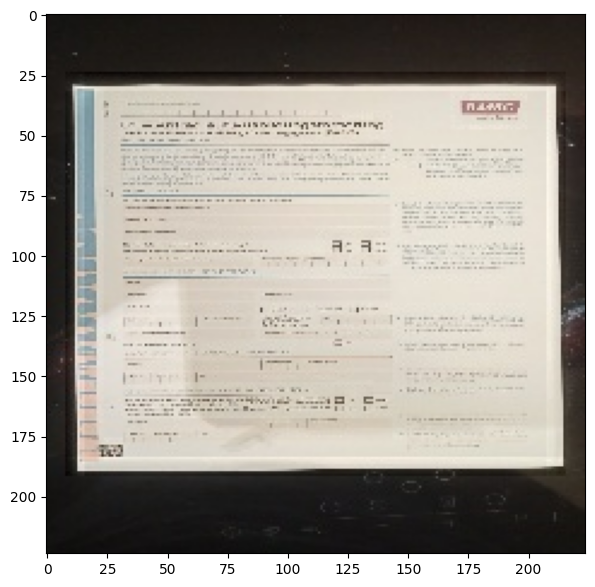

In [23]:
raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/train.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()


In [21]:
def prepare_sample(features):
    image = tf.image.resize(features["image"], size=(224, 224))
    return image, features["category_id"]


def get_dataset(filenames, batch_size):
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset


train_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*.tfrec")
batch_size = 1
epochs = 1
steps_per_epoch = 9
AUTOTUNE = tf.data.AUTOTUNE

input_tensor = tf.keras.layers.Input(shape=(224, 224, 3), name="image")
model = tf.keras.applications.EfficientNetB0(
    input_tensor=input_tensor, weights=None, classes=91
)


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


model.fit(
    x=get_dataset(train_filenames, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=1,
)


9/9 [==============================] - 23s 95ms/step - loss: 3.4065 - sparse_categorical_accuracy: 0.2222
